In [18]:
from read_ggp_run import *

In [19]:
# -------------------------------------------------- #
# Setup
# -------------------------------------------------- #

paramter_settings = {'mean_lambda': 'bound',
                    'gamma_lambda': 'bound',
                    'var_lambda': 'bound',
                    'mean_q': 'bound',
                    'gamma_q': 'bound',
                    'var_q':'bound',
                    'beta':'bound',
                    'var_x':'bound',
                    'var_g':'bound',
                    'var_dx':'bound',
                    'var_dg':'bound'} 

directory = '../data/var_dg/var_dg_0'
sample = 'var_dg_0'

filebase = default_filebase(directory, sample) # default
save_plots = True
# -------------------------------------------------- #


In [20]:
dat_file = get_data_file(directory, sample)

minimization_iter_file, minimization_final_file = get_minimization_file(filebase, paramter_settings)
scan_files = get_scan_files(filebase, paramter_settings)

prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

if save_plots:
    plot_file = filebase
else:
    plot_file = None 

## Paramter Scans
- 1D paramter scans 

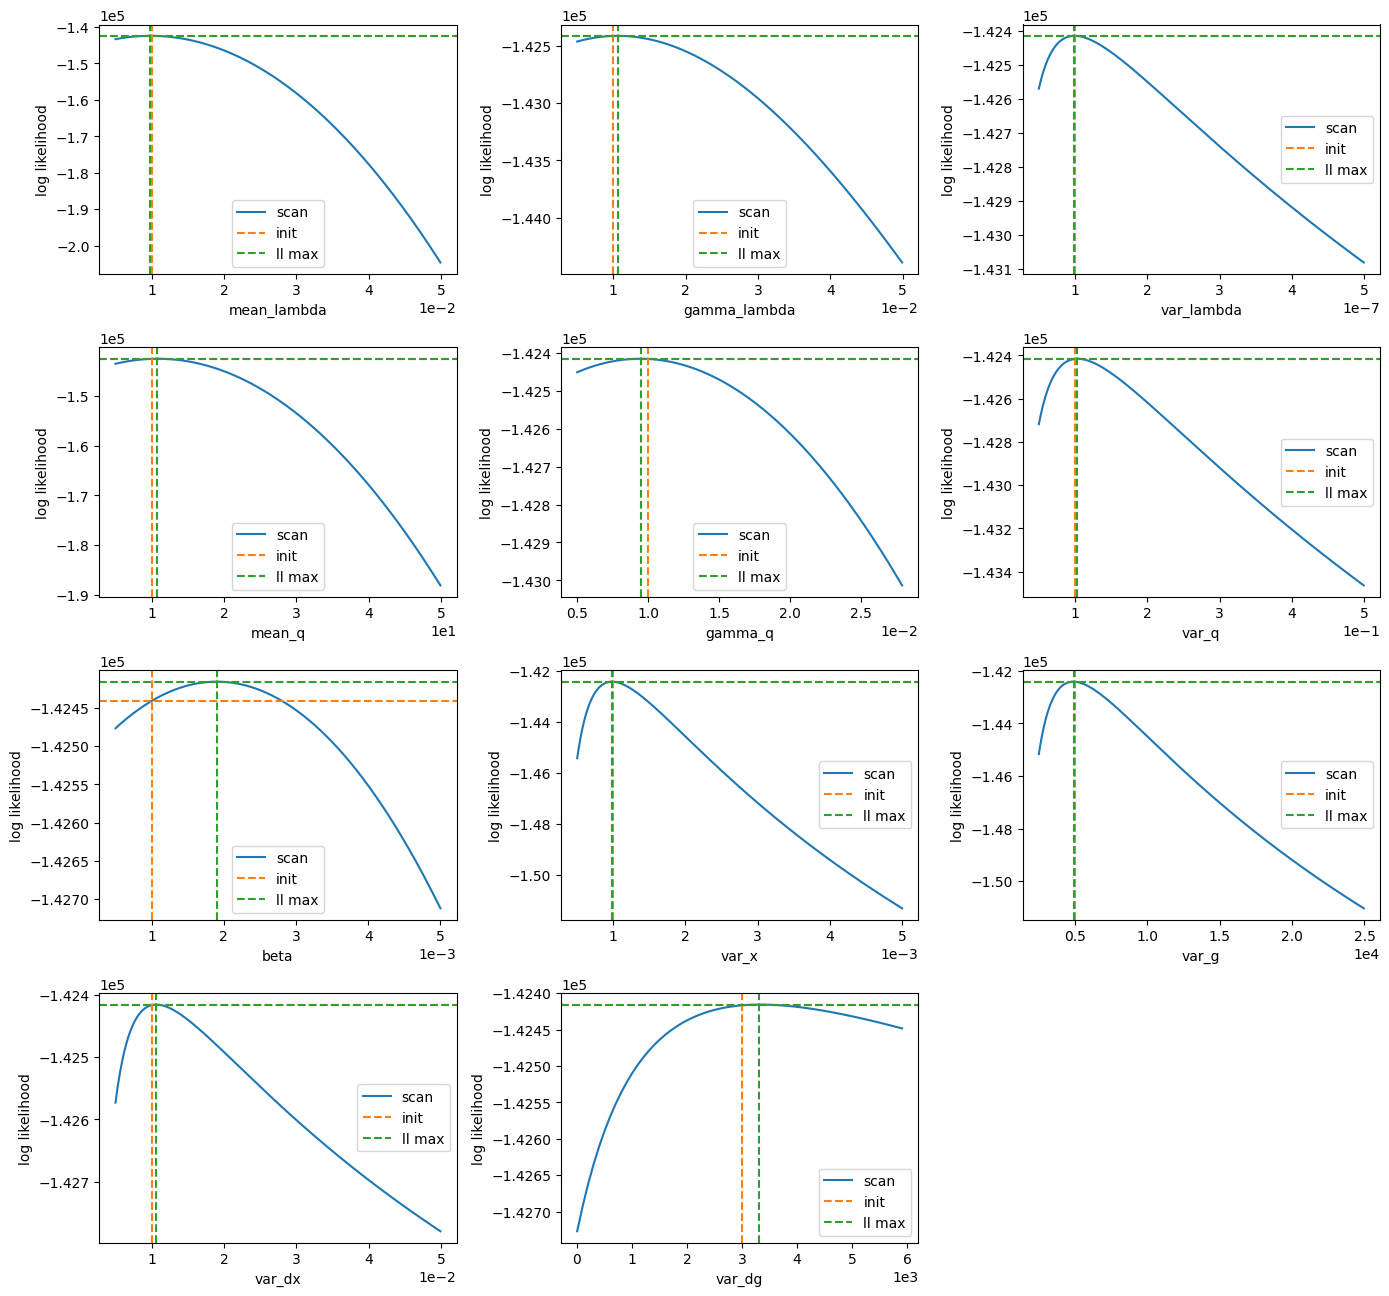

In [21]:
plot_1dscans(scan_files, plot_file)    


## Minimization
- plot the minimization process, ie the log likelihood for all iteration steps

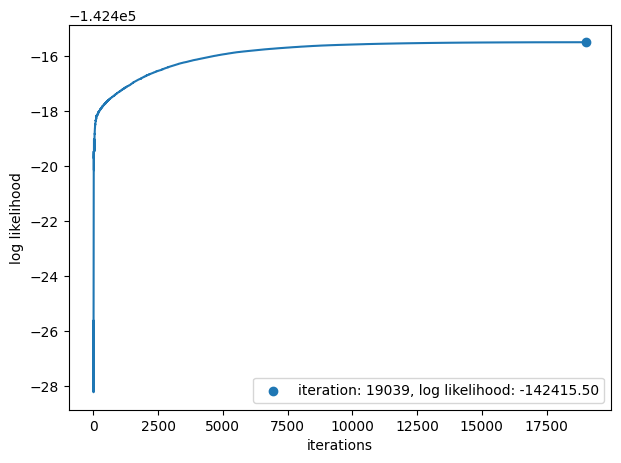

In [22]:

plot_minimization(minimization_iter_file, plot_file)

## Prediction
- plots the combined backward-forward prediction as well as both predictions seperately and the original data

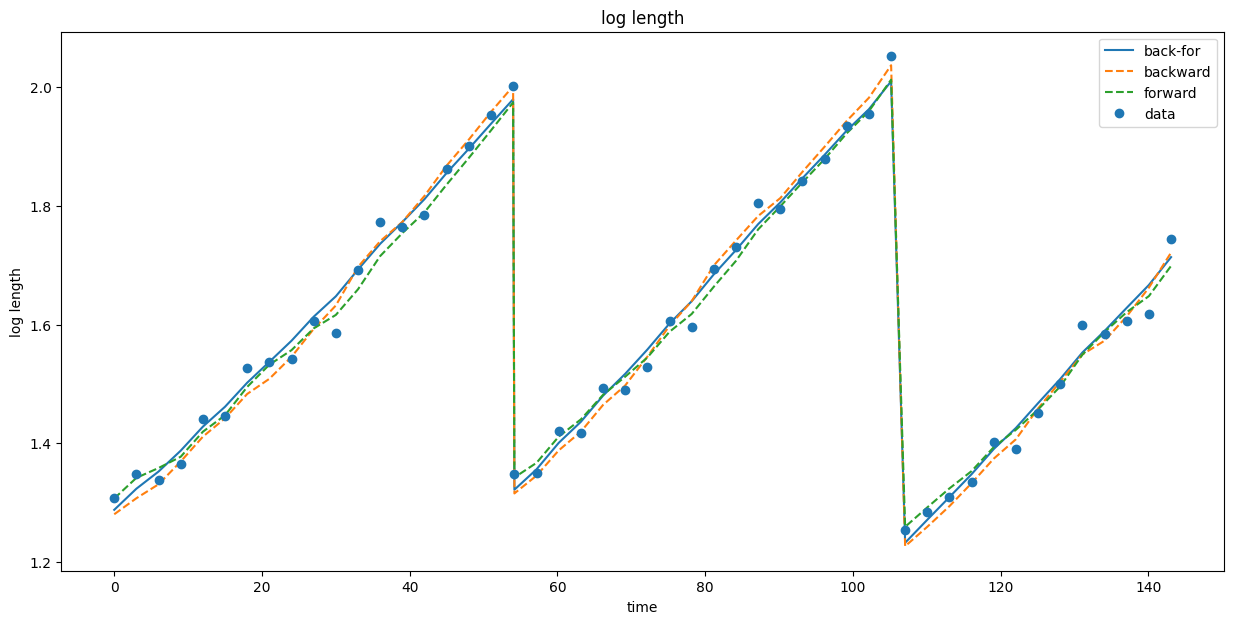

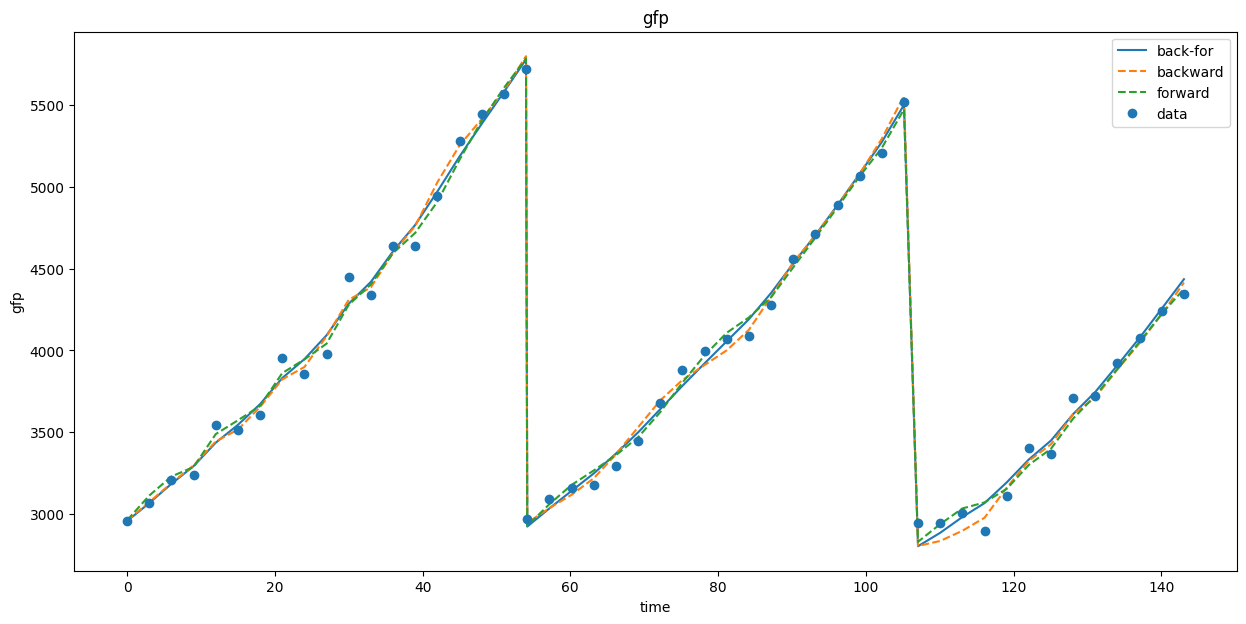

In [23]:
########################################################################
prediction = pd.read_csv(prediction_file, skiprows=13)
backward_prediction = pd.read_csv(prediction_file_b, skiprows=13)
forward_prediction = pd.read_csv(prediction_file_f, skiprows=13)

data_slice = slice(0, 50)

compare_predictions([prediction, backward_prediction, forward_prediction], ['back-for', 'backward', 'forward'], 'mean_x', prediction, 'log_length', data_slice, "log length", plot_file=plot_file)
compare_predictions([prediction, backward_prediction, forward_prediction], ['back-for', 'backward', 'forward'], 'mean_g', prediction, 'fp',data_slice, "gfp", plot_file=plot_file)


## Error estimation
- plot the error for a range of epsilons of the finit differnce estimation of the hessian, check if the estimation is numerically stable, ie close to constant for a range of epsilons

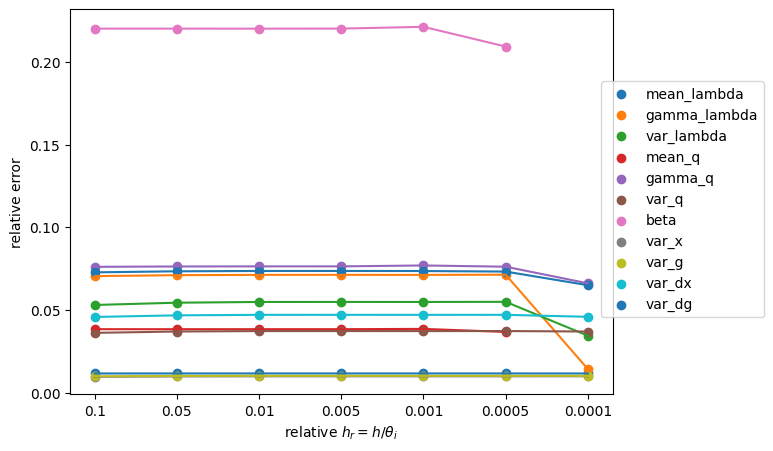

In [24]:
final_params = prediction = pd.read_csv(minimization_final_file, nrows=11)['final']
errors = prediction = pd.read_csv(minimization_final_file, skiprows=14)
    
plot_errors(errors, final_params, plot_file)

## Compare final and initial parameters

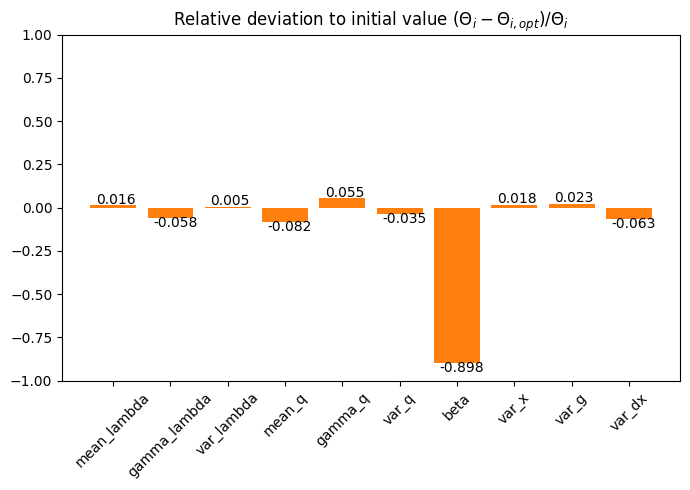

,parameter,simulation,minimization,relative deviation
0,mean_lambda,1.000000e-02,9.838240e-03,0.016176
1,gamma_lambda,1.000000e-02,1.058450e-02,-0.058450
2,var_lambda,1.000000e-07,9.945260e-08,0.005474
3,mean_q,1.000000e+01,1.082460e+01,-0.082460
4,gamma_q,1.000000e-02,9.453130e-03,0.054687
5,var_q,1.000000e-01,1.034860e-01,-0.034860
6,beta,1.000000e-03,1.898360e-03,-0.898360
7,var_x,1.000000e-03,9.824430e-04,0.017557
8,var_g,5.000000e+03,4.883550e+03,0.023290
9,var_dx,1.000000e-02,1.062990e-02,-0.062990


In [25]:

compare_init_final(minimization_iter_file, plot_file, ["var_dg"])
